Run moslin on C. elegans data using gridsearch results (ABpxp)
---

Use the hpyerparameters we identified in the gridsearch to produce a set of couplings, linking cells across time points with moslin.  

# Preliminaries

## Import packages

Configure JAX to use x64

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

Import other packages. 

In [3]:
# custom utilities
import utils

# single cell packages
import scanpy as sc
import scvelo as scv
import moscot as mc
import anndata

# rest
import pickle
import sys
import warnings
import numpy as np
import scipy.sparse as sp
import ott
import pandas as pd
from typing import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'interpolation_parameters' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'account_for_unbalancedness' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'batch_size' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'seed_interpolation' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


Print the moscot and OTT versions. 

In [4]:
mc.__version__

'0.1.1.dev45+g74fdbe8'

In [5]:
ott.__version__

'0.4.1.dev15+gd43f99d'

Check whether we are on GPU vs. CPU. 

In [6]:
from jax.lib import xla_bridge

xla_bridge.get_backend().platform

'cpu'

## Dependencies

This notebook depends on [ML_2023-03-31_prepare_data.ipynb](ML_2023-03-31_prepare_data.ipynb). 

## Define utility functions

In [7]:
def prepare_df(
    df: pd.DataFrame,
    *,
    lineage_info: Literal["precise", "abpxp"],
    method: Literal["moslin", "lot"] = "moslin"
):
    """Extract optimal hyperparameters from gridsearch"""

    # Filter to a subsampling strategy, and the method used to compute the coupling
    df = df.loc[df["config.lineage_info"] == lineage_info].copy()
    df = df.loc[df["config.kind"] == method].copy()

    # Compute the mean cost and find the minimum
    df["mean_cost"] = (df["result.early_cost"] + df["result.late_cost"]) / 2.0
    ixs = df.groupby(["config.kind", "config.tp"])["mean_cost"].idxmin()
    df = df.loc[ixs.reset_index()["mean_cost"]]

    # Prettify method names and time point labels
    df["config.kind"] = df["config.kind"].replace({"lot": "LineageOT"})

    df["config.tp"] = (
        df["config.tp"]
        .astype("str")
        .replace(
            {
                "[170, 210]": "170-210",
                "[210, 270]": "210-270",
                "[270, 330]": "270-330",
                "[330, 390]": "330-390",
                "[390, 450]": "390-450",
                "[450, 510]": "450-510",
            }
        )
    )

    return df

## Set up paths

Define the paths for data and figures

In [8]:
sys.path.insert(
    0, "../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [9]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

## Set global parameters

In [10]:
LINEAGE_INFO = "abpxp"
write_data = True

## Import the data

Import the AnnData object - this contains all cells for which we have at least partial lineage information. 

In [11]:
adata = sc.read(DATA_DIR / "ML_2023-03-31_c_elegans_prep.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'idx', 'barcode', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'clusters_colors', 'coarse_clusters_colors'

In addition, import the grid search results to inform our choice of hyperparematers. 

In [12]:
grid_df = pd.read_csv(
    DATA_DIR / "MK_2023-02-27_celegans_precise_and_abpxp.csv", index_col=0
)

# filter to runs that converged
grid_df = grid_df.loc[grid_df["result.converged"]]
grid_df.shape

(432, 13)

## Preprocessing and filtering

Subset to the ABpxp lineage, preprocess the data, compute PCA, and write the lineage tree to `.uns`. 

In [13]:
with open(DATA_DIR / "packer_lineage_tree.pkl", "rb") as file:
    full_reference_tree = pickle.load(file)
adata = utils.preprocess(adata, full_reference_tree, lineage_info=LINEAGE_INFO, seed=0)

Check what has been written

In [14]:
adata

AnnData object with n_obs × n_vars = 7356 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'log1p', 'hvg', 'pca', 'trees'
    obsm: 'X_pca'
    varm: 'PCs'

Subset to time points that contain enough cells to confidently map them. 

In [15]:
tps = [170, 210, 270, 330, 390, 450, 510]
adata = adata[adata.obs["assigned_batch_time"].isin(tps)].copy()
adata

AnnData object with n_obs × n_vars = 7274 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'log1p', 'hvg', 'pca', 'trees'
    obsm: 'X_pca'
    varm: 'PCs'

Prepare the gridsearch df

In [16]:
hyper_df = prepare_df(grid_df, lineage_info=LINEAGE_INFO, method="moslin")
hyper_df.head()

,_id,config.overwrite,config.db_collection,config.alpha,config.epsilon,config.kind,config.lineage_info,config.scale_cost,config.tp,config.seed,result.early_cost,result.late_cost,result.converged,mean_cost
73,74,74,celegans2,0.98,0.010,moslin,abpxp,mean,170-210,876241189,0.645808,0.595018,True,0.620413
143,144,144,celegans2,0.95,0.010,moslin,abpxp,mean,210-270,488805327,0.507591,0.493544,True,0.500567
213,214,214,celegans2,0.90,0.010,moslin,abpxp,mean,270-330,440600597,0.368815,0.354810,True,0.361813
311,312,312,celegans2,0.98,0.001,moslin,abpxp,mean,330-390,694821887,0.336692,0.294452,True,0.315572
373,374,374,celegans2,0.90,0.010,moslin,abpxp,mean,390-450,507144240,0.248349,0.184456,True,0.216403


Save the `.uns` anntations

In [17]:
uns_original = adata.uns.copy()

# Run moslin

## Loop over time points, compute couplings

In [18]:
adatas = {}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for t1, t2 in zip(tps[:-1], tps[1:]):
        # extract hyperparameters from gridsearch results
        params = hyper_df.loc[hyper_df["config.tp"] == f"{t1}-{t2}"]
        alpha = params["config.alpha"].values[0]
        epsilon = params["config.epsilon"].values[0]
        scale_cost = params["config.scale_cost"].values[0]

        # print these parameters and run moslin
        print(f"{t1=}, {t2=}, {epsilon=}, {alpha=} {scale_cost=}")
        prob, pred, conv, gt = utils.benchmark_moscot(
            adata,
            t1,
            t2,
            alpha=alpha,
            epsilon=epsilon,
            scale_cost=scale_cost,
        )

        # extract the internal AnnData object, and compute early and late cost
        bdata = prob.adata
        early_cost = gt.cost(pred, late=False)
        late_cost = gt.cost(pred, late=True)

        # Write the predicted and ground truth coupling, as well as the costs, to AnnData
        bdata = prob.adata
        src_ixs = np.where(bdata.obs["time"] == t1)[0]
        tgt_ixs = np.where(bdata.obs["time"] == t2)[0]
        d1 = sp.csc_matrix((len(src_ixs), len(src_ixs)))
        d2 = sp.csc_matrix((len(tgt_ixs), len(tgt_ixs)))

        bdata.obsp["pred"] = sp.bmat([[d1, pred], [None, d2]], format="csr")
        bdata.obsp["gt"] = sp.bmat([[d1, gt.coupling], [None, d2]], format="csr")
        bdata.uns["costs"] = {"early": early_cost, "late": late_cost}
        print(bdata.uns["costs"])
        adatas[t1, t2] = bdata

t1=170, t2=210, epsilon=0.01, alpha=0.98 scale_cost='mean'
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(190, 832)].                                    
{'early': 0.6458081318097335, 'late': 0.5950179972942952}
t1=210, t2=270, epsilon=0.01, alpha=0.95 scale_cost='mean'
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(832, 1787)].                                   
{'early': 0.507591920583242, 'late': 0.4935450814163852}
t1=270, t2=330, epsilon=0.01, alpha=0.9 scale_cost='mean'
WARNING  Dens

## Reconstruct anndata

In [19]:
bdatas, tmats = {}, {}
for i, ((t1, t2), bdata) in enumerate(adatas.items()):
    src_mask = bdata.obs["time"] == t1
    tgt_mask = bdata.obs["time"] == t2
    tmat = bdata.obsp["pred"][src_mask, :][:, tgt_mask]
    tmats[t1, t2] = anndata.AnnData(
        tmat, obs=bdata[src_mask].obs, var=bdata[tgt_mask].obs
    )
    # ugly stuff from previous notebook
    exec(f"a{i + 1} = bdata[src_mask]")
    exec(f"b{i + 1} = bdata[tgt_mask]")

subsets = [
    a1,
    b1[b1.obs_names.intersection(a2.obs_names)],
    b2[b2.obs_names.intersection(a3.obs_names)],
    b3[b3.obs_names.intersection(a4.obs_names)],
    b4[b4.obs_names.intersection(a5.obs_names)],
    b5[b5.obs_names.intersection(a6.obs_names)],
    b6,
]
for i, (t1, t2) in enumerate(zip(tps[:-1], tps[1:])):
    tmats[t1, t2] = tmats[t1, t2][subsets[i].obs_names, subsets[i + 1].obs_names]

In [20]:
adata = subsets[0].concatenate(subsets[1:], batch_key="time_point")
adata.obs_names = adata.obs_names.str.split("-").str[:2].str.join("-")
assert len(set(adata.obs_names)) == adata.n_obs
adata.obs["time_point"] = (
    adata.obs["time_point"]
    .cat.rename_categories(dict(zip(map(str, range(len(tps))), tps)))
    .astype("category")
)
adata

AnnData object with n_obs × n_vars = 6476 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time', 'marginals', 'time', 'time_point'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca'

Also write the `.uns` annotations back into AnnData

In [21]:
adata.uns = uns_original

## Visualize the embedding

In [22]:
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=30, random_state=0)
sc.tl.umap(adata, random_state=0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Prettify the colors a bit for temporal annotations. 

In [23]:
# assign time-point colors
adata.uns["time_point_colors"] = [
    mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(tps)))
]

# make timepoints categorical
adata.obs["raw.embryo.time"] = adata.obs["raw.embryo.time"].astype("category")
tps_raw = adata.obs["raw.embryo.time"].cat.categories

# assign colors to raw time points
adata.uns["raw.embryo.time_colors"] = [
    mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(tps_raw)))
]

Fix the ordering of coarse cluster annotations

In [24]:
# make them categorical again
adata.obs["coarse_clusters"] = adata.obs["coarse_clusters"].astype("category")

# write down the desired cluster order
nice_order = [
    "Ciliated neuron",
    "Ciliated preterminal neuron",
    "Non-ciliated neuron",
    "Non-ciliated preterminal neuron",
    "Glia and excretory",
    "Preterminal glia and excretory",
    "Other terminal cell",
    "Other preterminal cell",
    "Progenitor cell",
]
adata.obs["coarse_clusters"].cat.reorder_categories(nice_order, inplace=True)

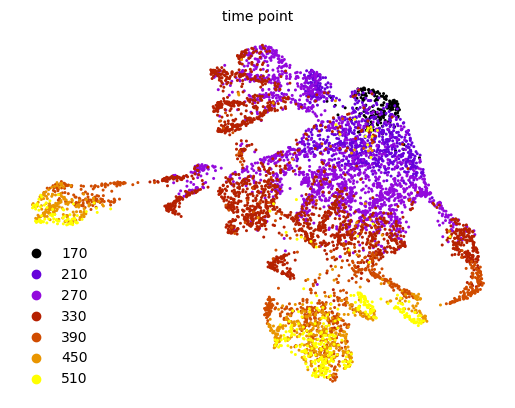

In [25]:
scv.pl.scatter(
    adata,
    basis="umap",
    color=["time_point"],
    legend_loc="best",
)

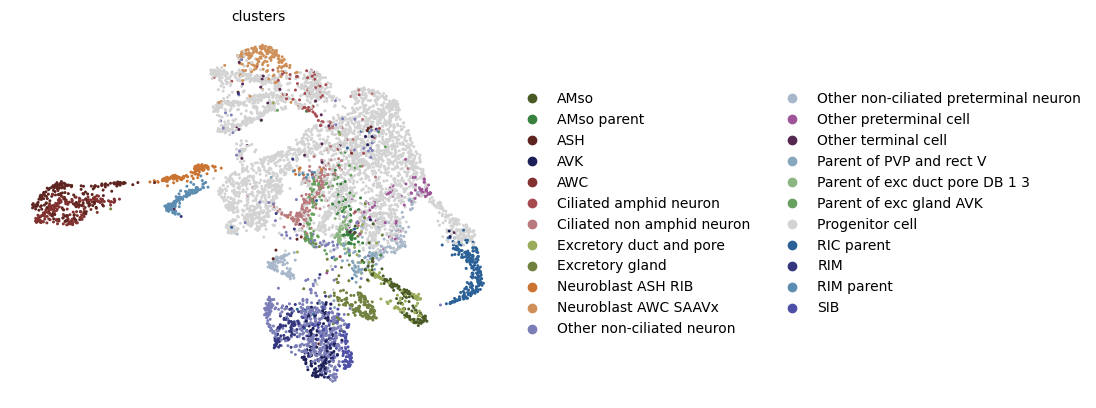

In [26]:
scv.pl.scatter(
    adata,
    basis="umap",
    color=["clusters"],
    legend_loc="right",
)

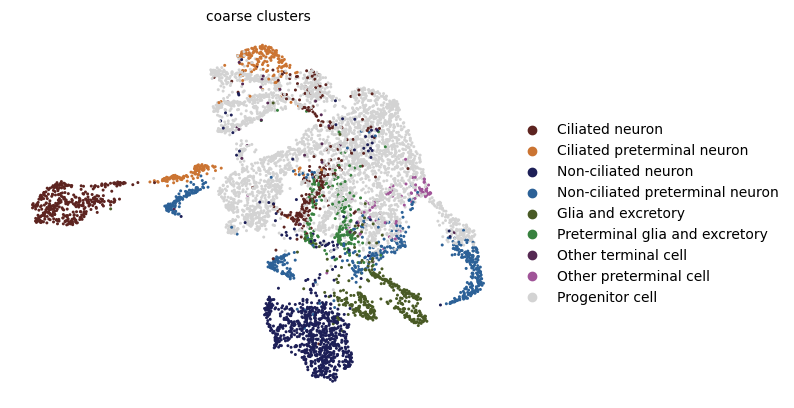

In [27]:
scv.pl.scatter(
    adata,
    basis="umap",
    color=["coarse_clusters"],
    legend_loc="right",
)

## Write to file

Write the AnnData, potentially remove the trees

In [28]:
if "trees" in adata.uns.keys():
    del adata.uns["trees"]

In [29]:
if write_data:
    # write the AnnData object
    adata.write(DATA_DIR / "ML_2023-03-31_c_elegans_abpxp_adata.h5ad")

    # write the couplings
    with open(DATA_DIR / "ML_2023-03-31_c_elegans_abpxp_tmats.pkl", "wb") as f:
        pickle.dump(tmats, f)